# Predicting car prices with KNN

In this project, we will use K-nearest neighbors algorithm to predict the prices of cars. [Here](https://archive.ics.uci.edu/ml/datasets/automobile) is the data set we will work on.

In [92]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
cars = pd.read_csv(
    'imports-85.data', 
    names=['symboling', 'normalized_losses', 'make','fuel_type','aspiration',
          'num_doors','body_style','drive_wheels','engine_location','wheel_base',
          'length','width','height','curb_weight','engine_type', 
          'num_cylinders','engine_size','fuel_system','bore','stroke',
          'compression_ratio', 'horsepower','peak_rpm','city_mpg','highway_mpg',
          'price'])
cars.head(3)

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


## Data cleaning

### Data transformation

There are some *?* in the columns. They should be missing value and we will replace it with *numpy.nan*.

In [94]:
cars[cars == '?'] = np.nan

In [95]:
# missing value in target, price
cars['price'].isna().sum()

4

There are 4 missing values in price. We will remove these rows since they do not have our target values.

In [96]:
cars.dropna(subset=['price'], inplace=True)

Some columns have a different type as expected. `normalized_losses`, `num_cylinders`, `bore`, `stroke`, `horsepower`, `peak_rpm` and `price` should be *numeric* instead of *object*. 

In [97]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
symboling            201 non-null int64
normalized_losses    164 non-null object
make                 201 non-null object
fuel_type            201 non-null object
aspiration           201 non-null object
num_doors            199 non-null object
body_style           201 non-null object
drive_wheels         201 non-null object
engine_location      201 non-null object
wheel_base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb_weight          201 non-null int64
engine_type          201 non-null object
num_cylinders        201 non-null object
engine_size          201 non-null int64
fuel_system          201 non-null object
bore                 197 non-null object
stroke               197 non-null object
compression_ratio    201 non-null float64
horsepower           199 non-nul

In [98]:
numeric_cars_col = []

# select all non-object columns
for col in cars.columns:
    if cars[col].dtype != 'object':
        numeric_cars_col.append(col)

# include object columns which should be numeric
numeric_cars_col.extend(
    ['normalized_losses', 'num_cylinders', 'horsepower', 
    'peak_rpm', 'bore', 'stroke', 'num_doors', 'price']
)

The values in `num_cylinders` and `num_doors` can be converted into numeric numbers.

In [99]:
cars['num_doors'].value_counts(dropna = False)

four    113
two      86
NaN       2
Name: num_doors, dtype: int64

In [100]:
cars['num_cylinders'].value_counts(dropna = False)

four      157
six        24
five       10
two         4
eight       4
twelve      1
three       1
Name: num_cylinders, dtype: int64

In [101]:
# map number strings into value
numerical_value = {'four': 4, 'six': 6, 'five':5, 'eight': 8, 'two': 2,
                   'three': 3, 'twelve': 12}

cars['num_cylinders'] = cars['num_cylinders'].map(numerical_value)
cars['num_doors'] = cars['num_doors'].map(numerical_value)

In [102]:
# set all columns as float
numeric_cars = cars[numeric_cars_col].astype('float')

### Missing values

Some columns still have missing values after we remove the rows with the missing price. We fill mean as their value.

In [103]:
print('Columns with missing values: \n')

for col in numeric_cars.columns:
    if any(numeric_cars[col].isnull()):
        missing = numeric_cars[col].isnull().sum()
        print(col, ':', missing, ',', round(missing/len(numeric_cars),4))
        
        # fill na with column mean
        numeric_cars[col].fillna(numeric_cars[col].mean(), inplace=True)

Columns with missing values: 

normalized_losses : 37 , 0.1841
horsepower : 2 , 0.01
peak_rpm : 2 , 0.01
bore : 4 , 0.0199
stroke : 4 , 0.0199
num_doors : 2 , 0.01


### Normalization

Since the ranges in each column are different, we have to normalize them to prevent any scaling problem.

In [104]:
features = numeric_cars[numeric_cars.columns.drop('price')]
features = (features - features.min())/(features.max()-features.min())
numeric_cars[numeric_cars.columns.drop('price')] = features

## Modelling

### Univariate model

Now we start with only 1 feature in k-nearest neighbors models with default k-value, 5.

In [105]:
def knn_train_test(col, target, df):
    # split training and testing set
    train, test = train_test_split(numeric_cars, 
                                   test_size=0.2, 
                                   random_state=1)
    
    knn = KNeighborsRegressor()
    knn.fit(train[[col]], train[target])
    predict_value = knn.predict(test[[col]])
    rmse = mean_squared_error(test[target], predict_value)**(1/2)
    return rmse

In [106]:
rmses = {}
for col in numeric_cars.columns.drop('price'):
    rmses[col] = knn_train_test(col, 'price', numeric_cars)

# sort features by rmse value
sorted(rmses.items(), key = lambda items: items[1] )

[('horsepower', 3259.000624162671),
 ('curb_weight', 3275.6848941639146),
 ('width', 3368.1703357656525),
 ('engine_size', 3496.576248902667),
 ('city_mpg', 3653.0031975041593),
 ('length', 3687.155336980582),
 ('highway_mpg', 4009.908052105617),
 ('num_cylinders', 5193.949944629528),
 ('wheel_base', 5209.971585522441),
 ('stroke', 6045.587048175981),
 ('peak_rpm', 6208.025557214177),
 ('bore', 6430.078604534148),
 ('normalized_losses', 6590.382697204294),
 ('height', 7026.460522284282),
 ('compression_ratio', 7105.987915801166),
 ('symboling', 7836.647600451262),
 ('num_doors', 9918.009918989328)]

`horsepower` seems to be the best parameter to predict the price when we take k=5. However, the result might change if we use different a k value.

In [107]:
def knn_train_test_k(col, target, df, k):
    # split training and testing set
    train, test = train_test_split(numeric_cars, 
                                   test_size=0.2, 
                                   random_state=1)
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train[[col]], train[target])
    predict_value = knn.predict(test[[col]])
    rmse = mean_squared_error(test[target], predict_value)**(1/2)
    return rmse

width                3096.018393
horsepower           3386.386776
curb_weight          3467.609745
engine_size          3575.613124
city_mpg             3676.569839
highway_mpg          3801.679875
length               3926.010097
wheel_base           4598.746096
num_cylinders        5084.728086
stroke               6268.190943
peak_rpm             6471.262746
compression_ratio    6986.208066
height               7030.707153
normalized_losses    7449.449232
symboling            7457.319191
bore                 7753.428073
num_doors            9524.907811
dtype: float64


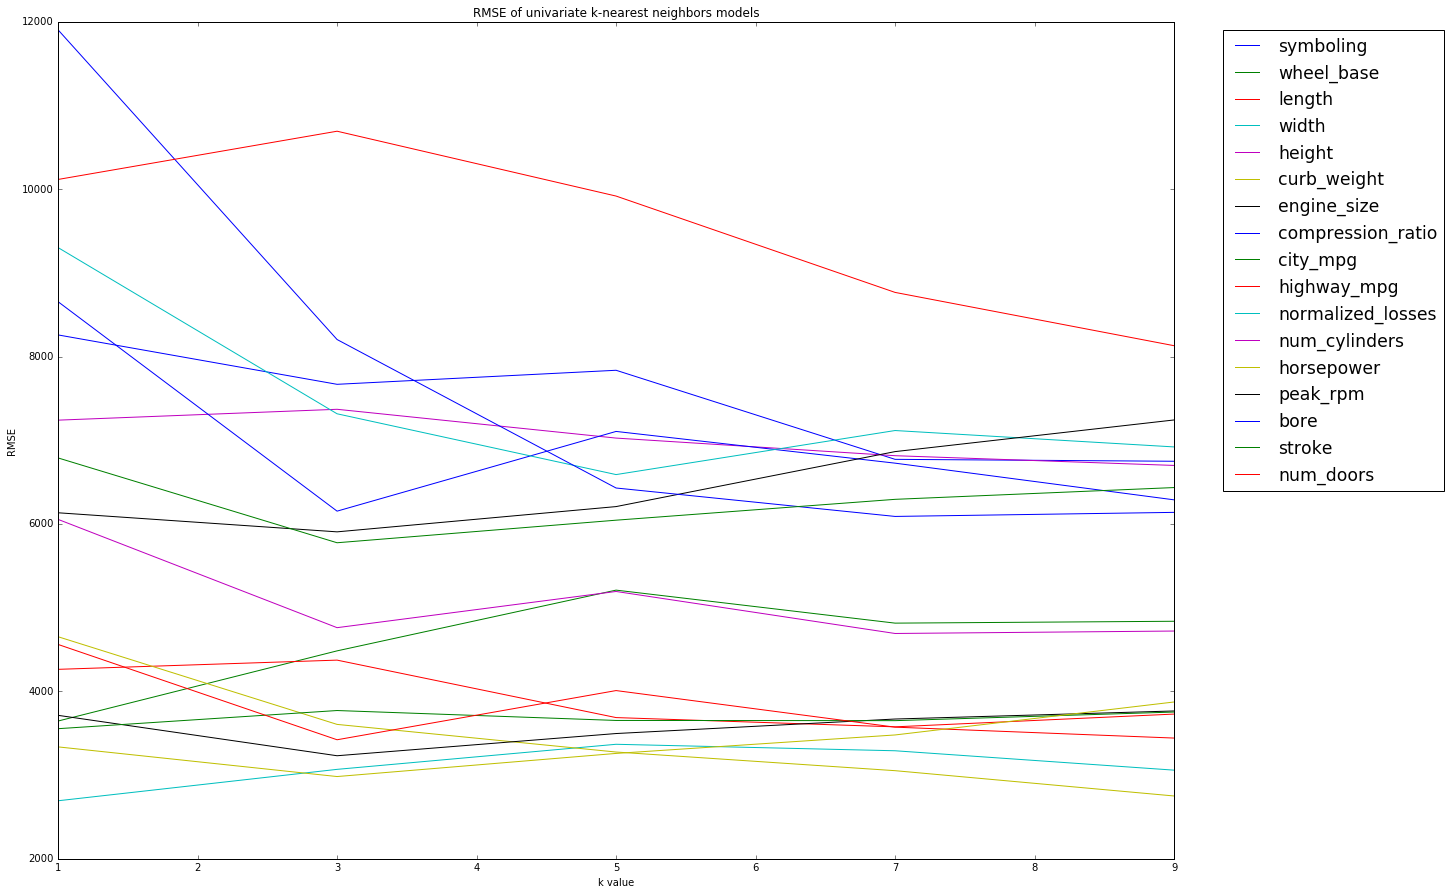

In [108]:
rmses_k = pd.DataFrame(columns = numeric_cars.columns.drop('price'),
                       index = [1,3,5,7,9])

for col in rmses_k.columns:
    for k in rmses_k.index:
        rmses_k.loc[k,col] = knn_train_test_k(col, 'price', numeric_cars, k)

print(rmses_k.apply('mean', axis=0).sort_values())

plt.figure(figsize=(20,15))
ax = plt.plot(rmses_k, label = rmses_k.columns)
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.title('RMSE of univariate k-nearest neighbors models')
plt.legend(rmses_k.columns, bbox_to_anchor=(1.25, 1), fontsize='xx-large')

Features with low rmse trend to have a relatively stable rmse among different k (1,3,5,7,9). The rmse of those features with high value drops when k increases. Among all, `width` is the best features to predict the price, with a mean rmse equals 3096. 

### Multivariates model

We try to add more features to the model and see if there is any improvement. We keep k equals to 5 first and try with 2-5 best features.

In [109]:
def knn_train_test_m(cols, target, df, k=5):
    # split training and testing set
    train, test = train_test_split(numeric_cars, 
                                   test_size=0.2, 
                                   random_state=1)
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train[cols], train[target])
    predict_value = knn.predict(test[cols])
    rmse = mean_squared_error(test[target], predict_value)**(1/2)
    return rmse

In [110]:
# Top n features
top_features = rmses_k.apply('mean', axis=0).sort_values().index
print('Top 5 best features are {}, {}, {}, {} and {}.'.format(
    top_features[0],
    top_features[1],
    top_features[2],
    top_features[3],
    top_features[4]))

multi_rmse = {}
for i in [2,3,4,5]:
    features = top_features[:i]
    multi_rmse['{} best features'.format(i)] = knn_train_test_m(features, 
                                                                'price', 
                                                                numeric_cars)
    
multi_rmse

Top 5 best features are width, horsepower, curb_weight, engine_size and city_mpg.


{'2 best features': 2507.4012336164833,
 '3 best features': 2313.967622093611,
 '4 best features': 2242.5972077253555,
 '5 best features': 2155.545008327784}

The rmse reduces when we have more features included. Let's try with all features.

In [111]:
# Model with all features
knn_train_test_m(top_features, 'price', numeric_cars)

3411.43981748069

Including all features does seem to be a good idea as we have a much higher rmse, 3411. The result is even worse than the univariate model. How about k value?

## Tuning hyperparameter

In [112]:
multi_k_rmse = pd.DataFrame(columns = range(2,5,1), # number of features
                            index = range(1,25,1)) # value of k

for k in range(1,25,1):
    for i in [2,3,4,5]:
        features = top_features[:i]
        multi_k_rmse.loc[
            k,i] = knn_train_test_m(features, 'price', numeric_cars, k)

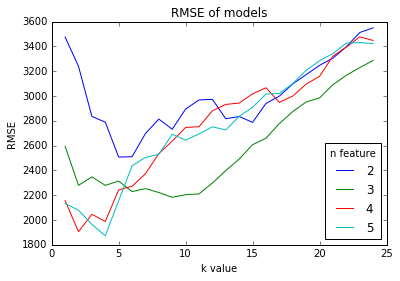

In [113]:
plt.plot(multi_k_rmse)
plt.legend(multi_k_rmse.columns, loc='best', title ='n feature')
plt.title('RMSE of models')
plt.xlabel('k value')
plt.ylabel('RMSE')

In [114]:
# min RMSE in each model
multi_k_rmse.apply('min',axis=0)

2    2507.401234
3    2183.250530
4    1905.314626
5    1872.560567
dtype: float64

## Conclusion

The best model we got is using the top 5 features (width, horsepower, curb_weight, engine_size and city_mpg) and 4 hyperparameters.